In [1]:
# !pip install opencv-python matplotlib pandas pillow tqdm

## Python Imports and Libraries

The following Python libraries and modules are imported to facilitate efficient data processing, image handling, visualization, and parallel computing:

- **os**: For interacting with the operating system (e.g., file and directory handling).
- **cv2 (OpenCV)**: Used for advanced image processing and computer vision operations.
- **numpy**: For numerical computations and handling arrays.
- **matplotlib.pyplot**: For visualizing images and plotting data.
- **pandas**: For structured data manipulation and analysis.
- **multiprocessing**: To utilize multiple CPU cores for parallel execution of tasks.
- **tqdm**: Provides a fast, extensible progress bar for loops and processing pipelines.
- **collections.Counter**: For counting hashable items efficiently.
- **PIL.Image**: For basic image loading and processing using the Python Imaging Library.
- **time**: To measure execution time and performance profiling.
- **dask.delayed & dask.compute**: For parallelizing and scheduling computations using Dask.
- **dask.distributed.Client**: To manage and distribute computation across multiple cores or nodes.

These libraries are essential for handling large-scale image datasets and speeding up computations through parallelism.

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
from collections import Counter
from PIL import Image
from time import time
from dask import delayed, compute
from dask.distributed import Client

## Dataset path (Dataset stored in scratch directory)

In [3]:
# Set dataset path (update as needed)
DATASET_PATH = "/scratch/panchani.d/Hpc/dataset"

## Image Path Extraction and Class Distribution Visualization

This section includes functions for retrieving image file paths from a hierarchical directory structure and visualizing the distribution of classes in the dataset.

- **`get_image_paths()`**:
  - Navigates through the dataset directory, where each subdirectory corresponds to a specific class label (e.g., different skin diseases).
  - Collects full image paths and associates them with their respective class labels.
  - Filters only image files with valid extensions (`.jpg`, `.png`, `.jpeg`).

- **`plot_class_distribution(class_labels)`**:
  - Takes a list of class labels extracted from the dataset.
  - Utilizes `Counter` to count the number of images per class.
  - Plots a bar chart showing the distribution of samples across different classes using `matplotlib`.

This step helps in understanding the dataset structure and identifying potential class imbalances before training a machine learning model.

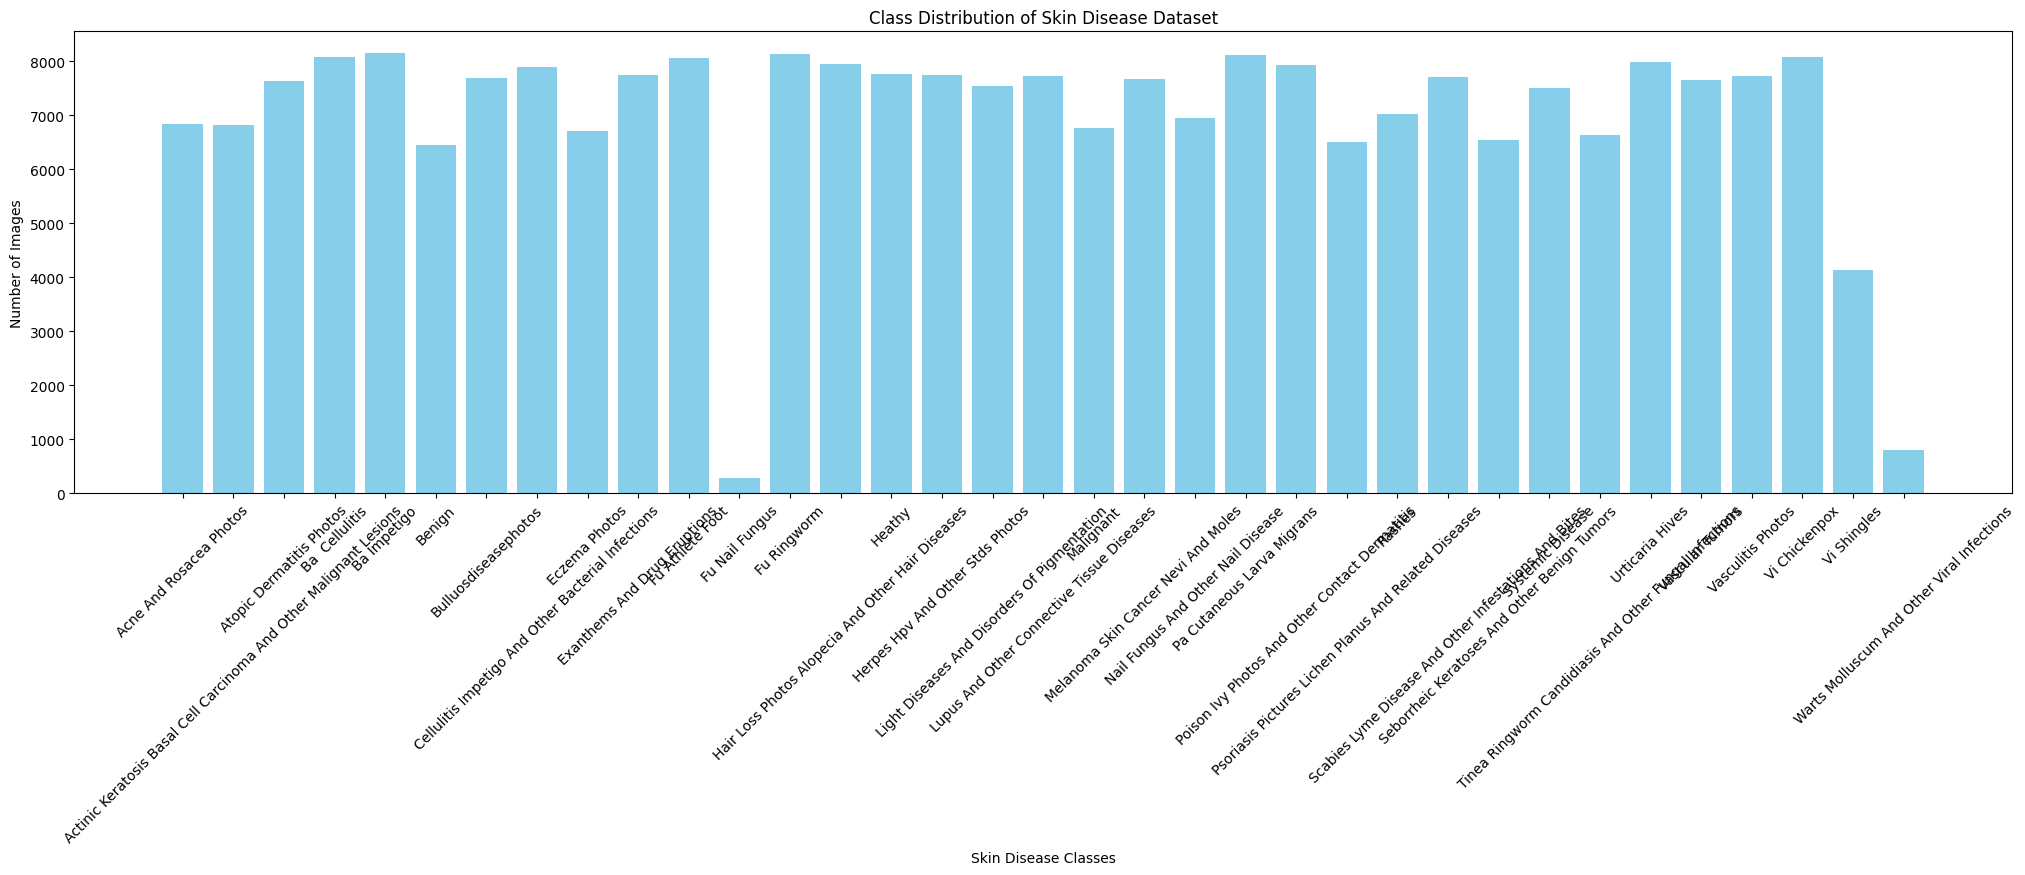

In [4]:
# Function to get image file paths
def get_image_paths():
    class_folders = [os.path.join(DATASET_PATH, d) for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    image_paths = []
    class_labels = []
    
    for class_folder in class_folders:
        label = os.path.basename(class_folder)
        for img_file in os.listdir(class_folder):
            img_path = os.path.join(class_folder, img_file)
            if img_path.endswith((".jpg", ".png", ".jpeg")):
                image_paths.append(img_path)
                class_labels.append(label)
    
    return image_paths, class_labels

# Load dataset image paths
image_paths, class_labels = get_image_paths()

# Plot class distribution
def plot_class_distribution(class_labels):
    class_counts = Counter(class_labels)
    plt.figure(figsize=(25, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xticks(rotation=45)
    plt.xlabel("Skin Disease Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution of Skin Disease Dataset")
    plt.show()

plot_class_distribution(class_labels)

## Parallel Image Shape Extraction

This section efficiently extracts the dimensions (width, height) of all images using parallel processing.

- **`get_image_shape()`**: Opens an image and returns its size.
- **`parallel_image_shapes()`**: Uses Python’s `multiprocessing.Pool` and `tqdm` for parallelized shape extraction with a progress bar.
- Measures and stores the execution time for different CPU core counts to analyze performance scaling.


In [5]:
# Function to get image shape
def get_image_shape(image_path):
    try:
        img = Image.open(image_path)
        return img.size  # (width, height)
    except:
        return None

# Parallel processing for image shapes
def parallel_image_shapes(image_paths, cpu_count):
    with Pool(processes=cpu_count) as p:
        image_shapes = list(tqdm(p.imap(get_image_shape, image_paths), total=len(image_paths)))
    return image_shapes


cpu_counts = [1,2,4,8]
# cpu_counts = [8, 12]
time_taken = []

for cpu_count in cpu_counts:
    start = time()
    image_shapes = parallel_image_shapes(image_paths, cpu_count)
    end = time()
    time_taken.append(end-start)

time_taken

100%|██████████| 245037/245037 [01:52<00:00, 2181.35it/s]


[864.8999893665314, 387.4461052417755, 199.04795455932617, 112.42221260070801]

### Number of CPUs Vs Time Graph

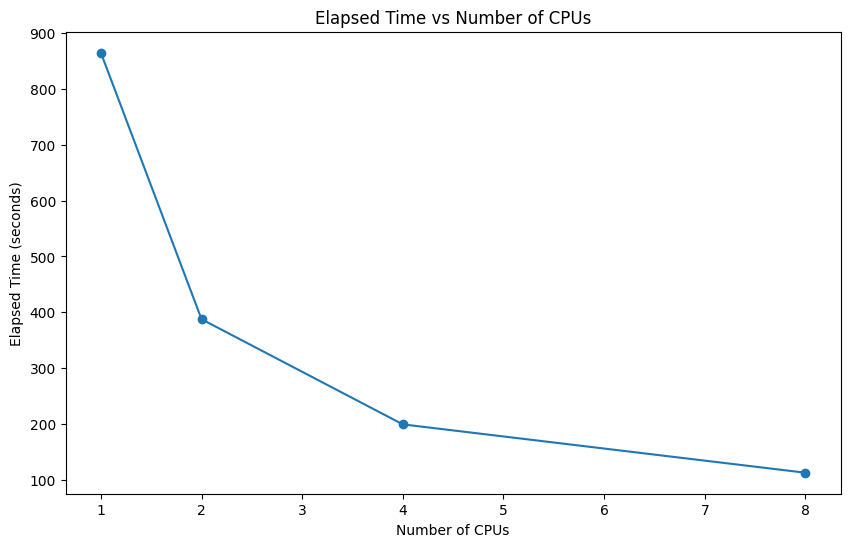

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, time_taken, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Elapsed Time (seconds)')
plt.title('Elapsed Time vs Number of CPUs')
plt.show()

### Number of CPUs Vs Speed Up Graph

[1.0, 2.2323104495444945, 4.345184009960516, 7.693319401552896]


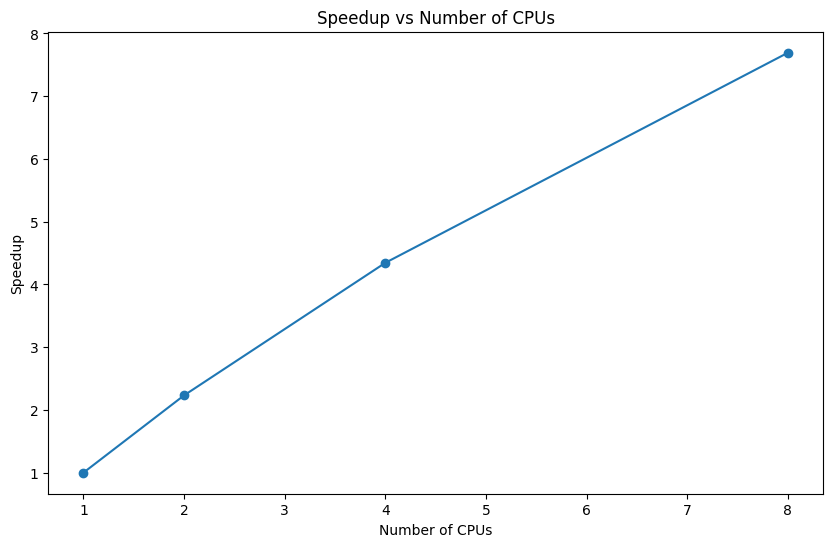

In [7]:
speedup = [time_taken[0] / t for t in time_taken]
print(speedup)
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, speedup, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Speedup')
plt.title(f'Speedup vs Number of CPUs')
plt.show()

### Number of CPUs Vs Efficiency Graph

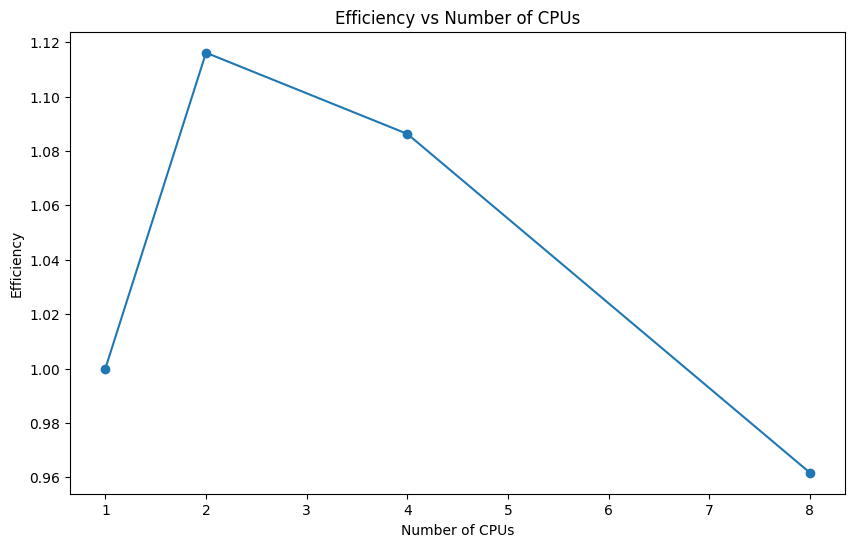

In [8]:
efficiency = [speedup[i] / cpu_counts[i] for i in range(len(cpu_counts))]
plt.figure(figsize=(10, 6))
plt.plot(cpu_counts, efficiency, marker='o')
plt.xlabel('Number of CPUs')
plt.ylabel('Efficiency')
plt.title(f'Efficiency vs Number of CPUs')
plt.show()

### Setting of Dask Client

In [9]:
from dask.distributed import Client

# Initialize the Dask client with 4 workers, 1 thread per worker, and processes=False
client = Client(n_workers=4, threads_per_worker=1)

# Display the client information
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40439,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39937,Total threads: 1
Dashboard: http://127.0.0.1:35011/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:33735,


## Image Size and Intensity Analysis

This section analyzes the dataset's image dimensions and pixel intensity distribution.

- Converts extracted image sizes into a DataFrame and plots width/height histograms to understand size variability.
- Uses Dask for parallel computation of grayscale pixel intensity histograms on a random sample of images.
- Aggregates and visualizes the average intensity distribution across sampled images.

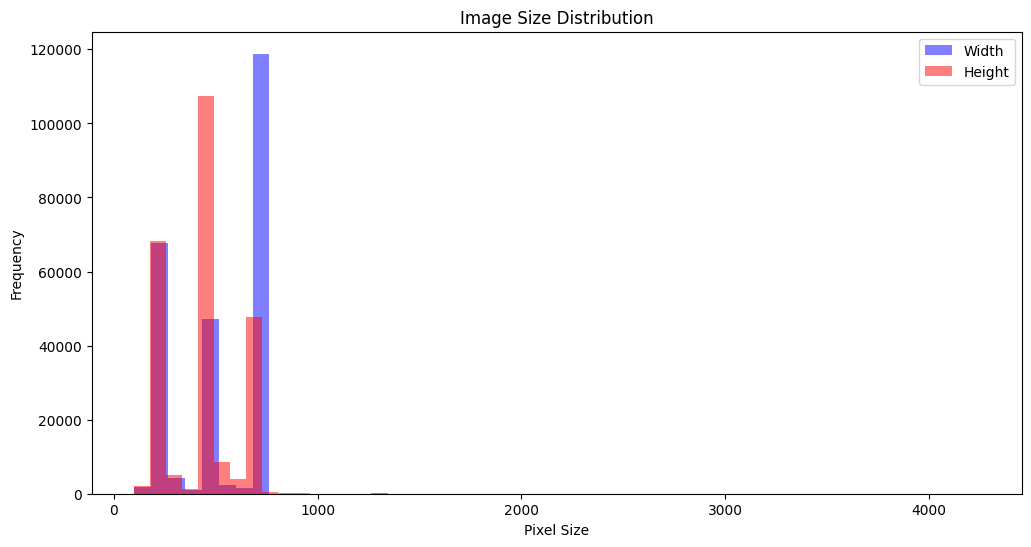

100%|██████████| 500/500 [00:00<00:00, 37086.88it/s]


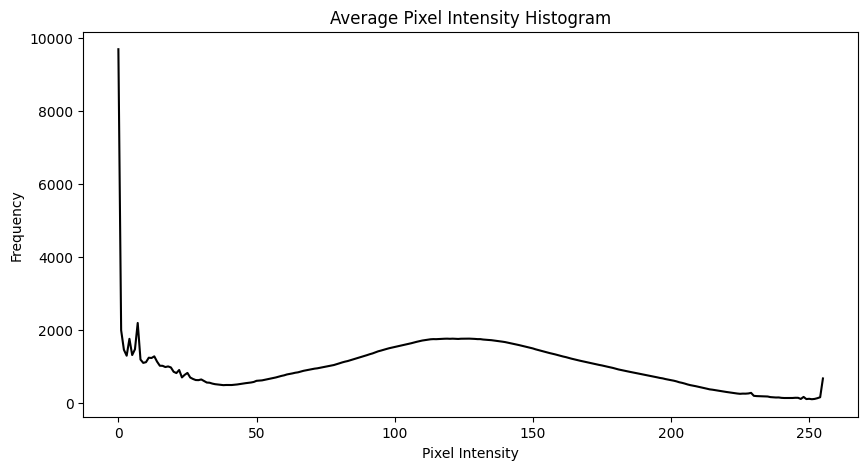

In [10]:
# Convert to DataFrame for analysis
image_sizes_df = pd.DataFrame(image_shapes, columns=["Width", "Height"])
image_sizes_df.dropna(inplace=True)

# Plot image size distribution
plt.figure(figsize=(12, 6))
plt.hist(image_sizes_df["Width"], bins=50, alpha=0.5, label="Width", color='blue')
plt.hist(image_sizes_df["Height"], bins=50, alpha=0.5, label="Height", color='red')
plt.xlabel("Pixel Size")
plt.ylabel("Frequency")
plt.title("Image Size Distribution")
plt.legend()
plt.show()

# Function to compute pixel intensity histogram
@delayed
def compute_intensity_histogram(image_path):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        hist = cv2.calcHist([img], [0], None, [256], [0, 256])
        return hist.flatten()
    except:
        return None

# Parallel processing for histograms using Dask
sample_size = 500
sample_paths = np.random.choice(image_paths, min(sample_size, len(image_paths)), replace=False)
histograms = compute(*[compute_intensity_histogram(img) for img in tqdm(sample_paths)])

# Plot aggregated intensity histogram
avg_histogram = np.mean([h for h in histograms if h is not None], axis=0)
plt.figure(figsize=(10, 5))
plt.plot(avg_histogram, color='black')
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Average Pixel Intensity Histogram")
plt.show()

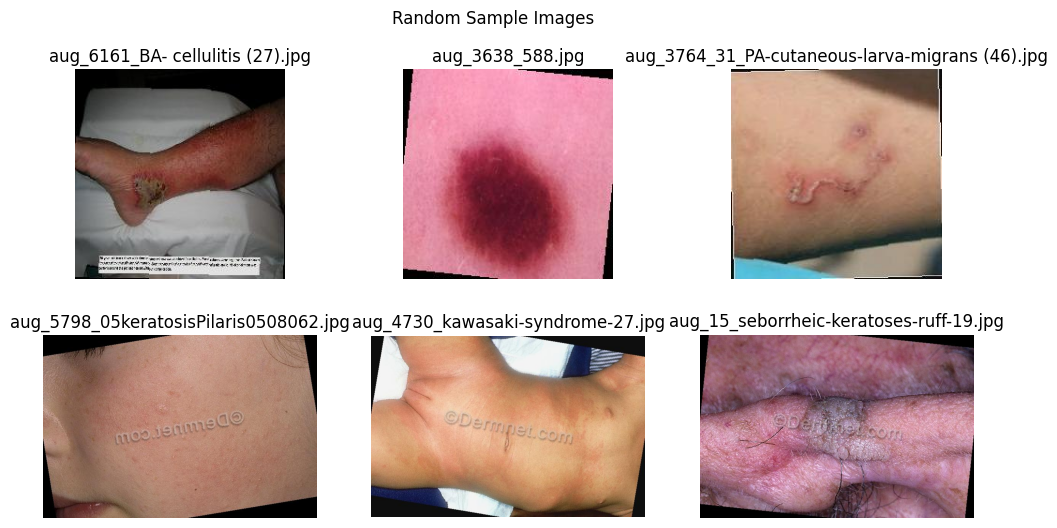

In [11]:
# Display random sample images
def show_sample_images(image_paths, num_samples=6):
    sample_paths = np.random.choice(image_paths, num_samples, replace=False)
    plt.figure(figsize=(12, 6))
    
    for i, img_path in enumerate(sample_paths):
        img = Image.open(img_path)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(os.path.basename(img_path))
    
    plt.suptitle("Random Sample Images")
    plt.show()

show_sample_images(image_paths)